In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [73]:
# 3-layer CNN model
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),  # Conv layer with 16 outputs
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Max Pooling with 2x2 kernel
            
            nn.Conv2d(16, 32, kernel_size=5, padding=2),  # Conv layer with 32 outputs
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),  # Conv layer with 64 outputs
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),  # Flatten layer to convert 2D feature maps to 1D
            
            nn.Linear(64 * 3 * 3, 30),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(30, 10),  # Output layer with 10 classes
            nn.Softmax(dim=1)  # Softmax activation for classification
        )

    def forward(self, x):
        return self.model(x)

In [74]:
# Load an example image from the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_dataset, batch_size=1, shuffle=True)

# Get a single example image and label
example_data, example_label = next(iter(data_loader))
example_data = example_data.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

model_3_layer = CNN3().to(device)
summary(model_3_layer, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          51,264
              ReLU-8             [-1, 64, 7, 7]               0
         MaxPool2d-9             [-1, 64, 3, 3]               0
          Flatten-10                  [-1, 576]               0
           Linear-11                   [-1, 30]          17,310
             ReLU-12                   [-1, 30]               0
           Linear-13                   [-1, 10]             310
          Softmax-14                   

In [75]:
# Define a hook function to capture the output of each layer
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks for all layers of interest
model_3_layer.model[0].register_forward_hook(get_activation('conv1'))   # Conv layer 1
model_3_layer.model[2].register_forward_hook(get_activation('pool1'))   # Max Pool layer 1
model_3_layer.model[3].register_forward_hook(get_activation('conv2'))   # Conv layer 2
model_3_layer.model[5].register_forward_hook(get_activation('pool2'))   # Max Pool layer 2
model_3_layer.model[6].register_forward_hook(get_activation('conv3'))   # Conv layer 3
model_3_layer.model[8].register_forward_hook(get_activation('pool3'))   # Max Pool layer 3
model_3_layer.model[9].register_forward_hook(get_activation('flatten')) # Flatten layer
model_3_layer.model[10].register_forward_hook(get_activation('fc1'))    # Fully connected layer 1
model_3_layer.model[12].register_forward_hook(get_activation('fc2'))    # Fully connected output layer

# Forward pass through the model to capture activations
output = model_3_layer(example_data)

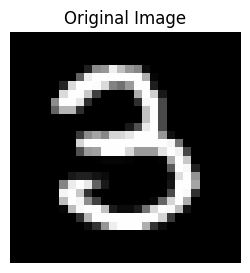

In [76]:
import matplotlib.pyplot as plt

def visualize_feature_maps(original_image):

    # Plot the image
    plt.figure(figsize=(3, 3))
    plt.imshow(original_image.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

# Visualize the example image from MNIST
visualize_feature_maps(example_data)

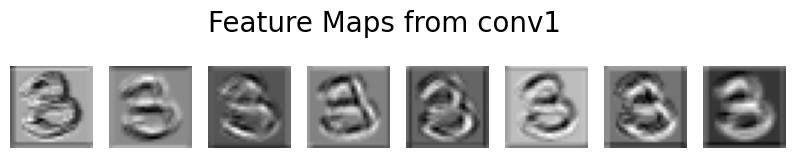

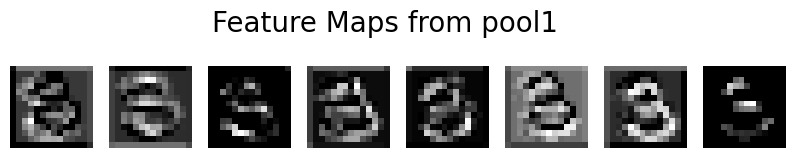

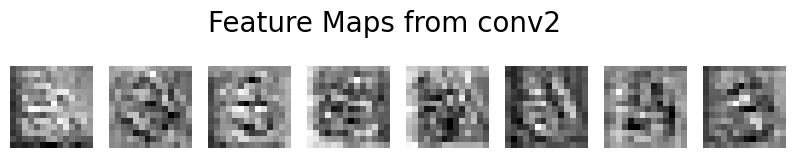

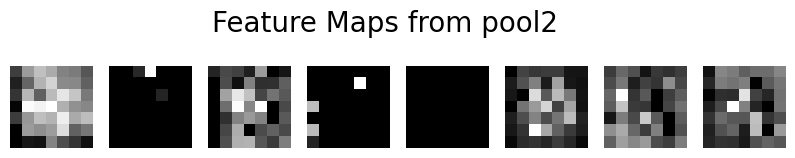

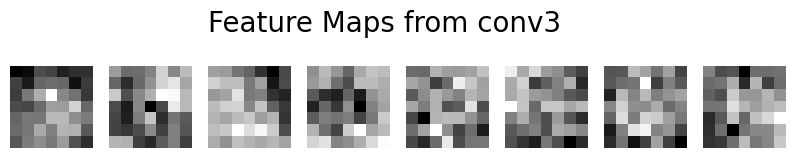

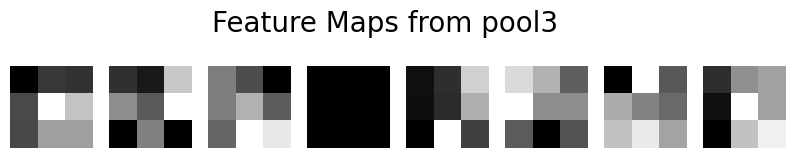

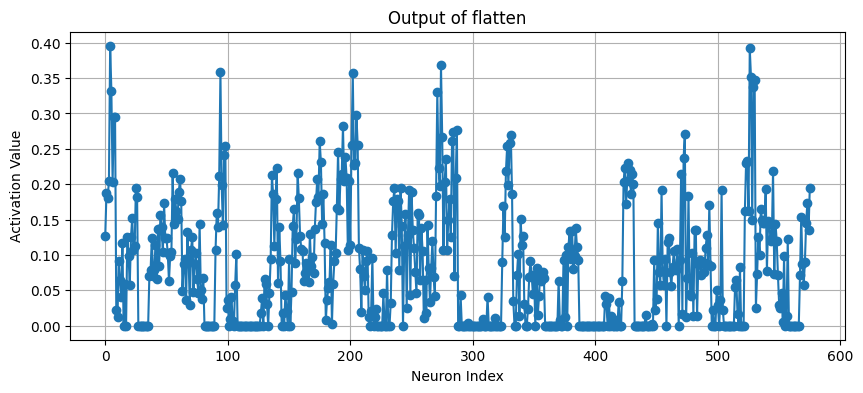

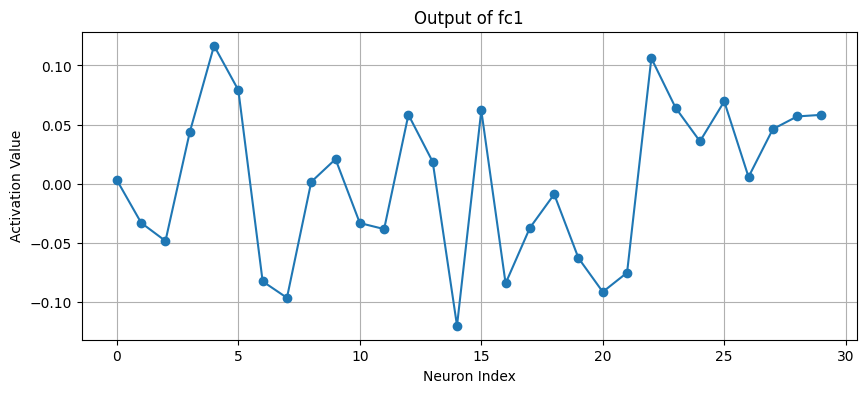

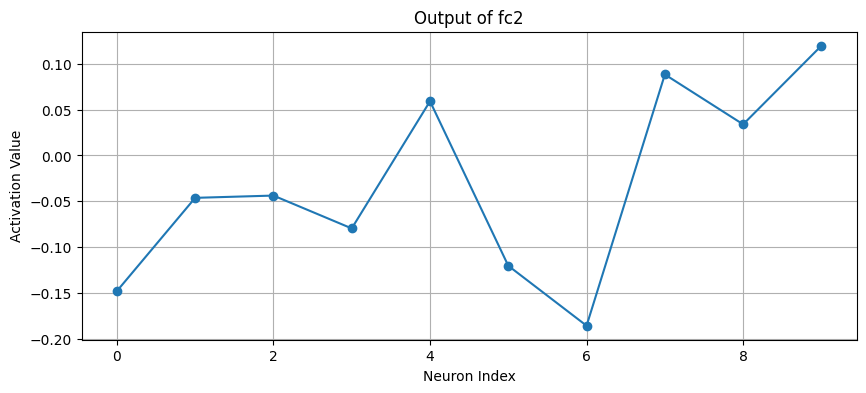

In [77]:
# Function to plot feature maps for convolutional and pooling layers
def plot_feature_maps(activation, layer_name, num_images=8):
    features = activation[layer_name].cpu()
    num_filters = features.shape[1]  # Number of channels or filters
    
    # Plot the first few filters or feature maps
    fig, axarr = plt.subplots(1, min(num_filters, num_images), figsize=(10, 2))
    for idx in range(min(num_filters, num_images)):
        axarr[idx].imshow(features[0, idx].numpy(), cmap='gray')
        axarr[idx].axis('off')
    plt.suptitle(f'Feature Maps from {layer_name}', fontsize=20)
    plt.show()

# Function to plot the output of fully connected layers
def plot_fc_layer(activation, layer_name):
    output = activation[layer_name].cpu().numpy().flatten()
    plt.figure(figsize=(10, 4))
    plt.plot(output, marker='o')
    plt.title(f'Output of {layer_name}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Activation Value')
    plt.grid(True)
    plt.show()

# Plot feature maps and activations for each registered layer
plot_feature_maps(activation, 'conv1')
plot_feature_maps(activation, 'pool1')
plot_feature_maps(activation, 'conv2')
plot_feature_maps(activation, 'pool2')
plot_feature_maps(activation, 'conv3')
plot_feature_maps(activation, 'pool3')

# Plot activations of fully connected and flatten layers
plot_fc_layer(activation, 'flatten')
plot_fc_layer(activation, 'fc1')
plot_fc_layer(activation, 'fc2')
